# Energy Analysis
We will be using the new energy layer to analyze the following future PV options
- SHJ
- Perovskite (tandem?)
- 50-year PERC module (multiple uses)
- Recycled Si PERC (Fraunhofer)
- Cheap crap module
- CdTe?

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
#creating scenarios for identical power of multiple technologies
scennames = ['PV_ICE','PERC_50','SHJ','Perovskite','RecycledPERC']#,'CheapCrap','Repowered'] #
MATERIALS = ['glass','silver','silicon', 'copper', 'aluminium_frames'] #'encapsulant', 'backsheet',
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [3]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


## Module Types Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [4]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'PERC_50', 'SHJ', 'Perovskite', 'RecycledPERC'])

In [5]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [6]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [7]:
#time shift for modifications

In [8]:
sim_start_year = sim1.scenario['Perovskite'].dataIn_m.iloc[0,0]
mod_start_year = 2022
timeshift = mod_start_year - sim_start_year
print('Time shift: '+str(timeshift))

Time shift: 27


### PERC_50
This module represents current PERC technology (so good efficiency) if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. It is assumed that this module is no more recyclable than current technology (downcycle glass and recycle aluminium frames).

In [9]:
#module efficiency modify for PERC
sim1.modifyScenario('PERC_50', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [10]:
#silver modify for PERC
sim1.scenario['PERC_50'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [11]:
#modify package to glass glass
sim1.scenario['PERC_50'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #

In [12]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('PERC_50', 'mod_degradation', 0.445, start_year=2022) #annual power degradation to reach 80% at 50 yrs
#T50
sim1.modifyScenario('PERC_50', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('PERC_50', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('PERC_50', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [13]:
#Merchant Tail set high
sim1.modifyScenario('PERC_50', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail
#Change recycling?

### SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [14]:
#module efficiency modify for PERC
sim1.modifyScenario('SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [15]:
#modify silver usage for SHJ
sim1.scenario['SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [16]:
#modify package to glass glass
sim1.scenario['SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [17]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('SHJ', 'mod_degradation', 0.5, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('SHJ', 'mod_lifetime', 30, start_year=2022) #project lifetime of 30 years
#T50
sim1.modifyScenario('SHJ', 'mod_reliability_t50', 28, start_year=2022)
#t90
sim1.modifyScenario('SHJ', 'mod_reliability_t90', 33, start_year=2022) 


In [18]:
#Merchant Tail set high
sim1.modifyScenario('SHJ', 'mod_MerchantTail', 50, start_year=2022) #50% stay for merchant tail, possibly change to DYNAMIC
#recycling?!?!

### Perovskite
This perovskite module uses current best module and cell efficiencies, has a prospective life of 15 years and 1.5% degradation rate, and is highly circular. This is a best case scenario for perovskites given current data.

In [19]:
#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 32.5% # https://www.nrel.gov/pv/assets/pdfs/best-research-cell-efficiencies.pdf
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9
df_perovskite_eff.loc[2050] = 32.5
df_perovskite_eff.interpolate(inplace=True)

In [20]:
#module efficiency modify for PERC
sim1.modifyScenario('Perovskite', 'mod_eff', df_perovskite_eff['mod_eff_p'], start_year=2022) #changing module eff

In [21]:
#modify package to glass glass
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [22]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('Perovskite', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('Perovskite', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('Perovskite', 'mod_reliability_t50', 14, start_year=2022)
#t90
sim1.modifyScenario('Perovskite', 'mod_reliability_t90', 20, start_year=2022) 

In [23]:
#As Circular as possible
#100% collection rate
sim1.modifyScenario('Perovskite', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection
sim1.modifyScenario('Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) #100% collection
sim1.modifyScenario('Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('Perovskite', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('Perovskite', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('Perovskite', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('Perovskite', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('Perovskite', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('Perovskite', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('Perovskite', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 99.0, start_year=2022) #99% yield
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send none to recycle
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_ReMFG_yield', 99.0, start_year=2022) #99% yeild
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_Recycling_yield', 99.0, start_year=2022) #99% yeild


#silicon Recycle (or should it be remfg?)
#mfg scrap
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_ReMFG_yield', 0.0, start_year=2022) #99% yeild

#aluminium_frames recycle
#mfg scrap
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 99.0, start_year=2022) #98% yield
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 99.0, start_year=2022) #99% yeild
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild


#### Recycled PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html

In [24]:
#https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html
#lets assume this gets slightly better over time
idx_RePerc_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_RePerc_eff = pd.DataFrame(index=idx_RePerc_eff, columns=['mod_eff_RePerc'], dtype=float)
df_RePerc_eff.loc[2022] = 19.7
df_RePerc_eff.loc[2050] = 22.2
df_RePerc_eff.interpolate(inplace=True)

In [25]:
#module efficiency
sim1.modifyScenario('RecycledPERC', 'mod_eff', df_RePerc_eff['mod_eff_RePerc'], start_year=2022)

In [26]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('RecycledPERC', 'mod_degradation', 0.8, start_year=2022) #slightly higher than current std
#Mod Project Lifetime
sim1.modifyScenario('RecycledPERC', 'mod_lifetime', 20, start_year=2022) #project lifetime of 20 years
#T50
sim1.modifyScenario('RecycledPERC', 'mod_reliability_t50', 21, start_year=2022)
#t90
sim1.modifyScenario('RecycledPERC', 'mod_reliability_t90', 26, start_year=2022) 

In [27]:
#silicon recycled
#mfg scrap
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#aluminium_frames recycle
#mfg scrap
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 99.0, start_year=2022) #98% yield
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 99.0, start_year=2022) #99% yeild
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

In [28]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)

In [29]:
altHQRecycle_e

E_MFG_kWhpkg  E_mfgFuelFraction
1995    600.817735           0.064489
1996    527.042434           0.072326
1997    485.167804           0.077357
1998    432.693843           0.085473
1999    380.620553           0.095834
2000    269.697933           0.075408
2001    236.759317           0.066235
2002    204.221370           0.054188
2003    172.084094           0.037719
2004    159.669155           0.030097
2005    140.254886           0.022532
2006    130.586287           0.022463
2007    121.318358           0.022639
2008    112.451100           0.023120
2009    103.984511           0.023976
2010     95.918593           0.025298
2011     88.253345           0.027195
2012     88.388767           0.027307
2013     88.924859           0.027745
2014     89.861622           0.028498
2015     91.199054           0.029547
2016     76.337157           0.037576
2017     61.875930           0.049814
2018     62.915373           0.053028
2019     64.355487           0.056410
2020     74.096270           0.053503
2021     77.837724           0.055738
2022     77.837724           0.055738
2023     77.837724           0.055738
2024     77.837724           0.055738
2025     77.837724           0.055738
2026     77.837724           0.055738
2027     77.837724           0.055738
2028     77.837724           0.055738
2029     77.837724           0.055738
2030     77.837724           0.055738
2031     77.837724           0.055738
2032     77.837724           0.055738
2033     77.837724           0.055738
2034     77.837724           0.055738
2035     77.837724           0.055738
2036     77.837724           0.055738
2037     77.837724           0.055738
2038     77.837724           0.055738
2039     77.837724           0.055738
2040     77.837724           0.055738
2041     77.837724           0.055738
2042     77.837724           0.055738
2043     77.837724           0.055738
2044     77.837724           0.055738
2045     77.837724           0.055738
2046     77.837724           0.055738
2047     77.837724           0.055738
2048     77.837724           0.055738
2049     77.837724           0.055738
2050     77.837724           0.055738

In [30]:
sim1.scenario['RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [31]:
sim1.scenario['RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction  e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062     169.06                    0.22   
26  2021            0.0062     170.73                    0.21   
27  2022            0.0062     169.05                    0.20   
28  2023            0.0062     168.80                    0.20   
29  2024            0.0062     169.09                    0.20   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25               24.5              600.0            0.09   
26               24.5              600.0            0.09   
27               24.5              600.0            0.09   
28               24.5              600.0            0.09   
29               24.5              600.0            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                          0.0                    0.4                1.6   
26                          0.0                    0.4                1.6   
27                          0.0                    0.4                1.6   
28                          0.0                    0.4                1.6   
29                          0.0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25         138.380000                        0.200000  
26         143.040000                        0.190000  
27          77.837724                        0.055738  
28          77.837724                        0.055738  
29          77.837724                        0.055738

#### Cheap Crap

#### Repowered

### Modify Years 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [32]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100


In [33]:
#check
sim1.scenario['SHJ'].material['glass'].matdataIn_e

year  e_mat_extraction  e_mat_MFG  e_mat_MFG_fuelfraction  \
0    2000            0.0062   4.434640               80.005988   
1    2001            0.0062   4.382279               79.998397   
2    2002            0.0062   4.318724               80.200079   
3    2003            0.0062   4.255168               80.409933   
4    2004            0.0062   4.191613               80.628330   
..    ...               ...        ...                     ...   
96   2096            0.0062   3.512724               86.798744   
97   2097            0.0062   3.512724               86.798744   
98   2098            0.0062   3.512724               86.798744   
99   2099            0.0062   3.512724               86.798744   
100  2100            0.0062   3.512724               86.798744   

     e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
0                  1.4                1.4            0.09   
1                  1.4                1.4            0.09   
2                  1.4                1.4            0.09   
3                  1.4                1.4            0.09   
4                  1.4                1.4            0.09   
..                 ...                ...             ...   
96                 1.4                1.4            0.09   
97                 1.4                1.4            0.09   
98                 1.4                1.4            0.09   
99                 1.4                1.4            0.09   
100                1.4                1.4            0.09   

     e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
0                           78.0                   0.61                1.4   
1                           78.0                   0.61                1.4   
2                           78.0                   0.61                1.4   
3                           78.0                   0.61                1.4   
4                           78.0                   0.61                1.4   
..                           ...                    ...                ...   
96                          78.0                   0.61                1.4   
97                          78.0                   0.61                1.4   
98                          78.0                   0.61                1.4   
99                          78.0                   0.61                1.4   
100                         78.0                   0.61                1.4   

     ...  e_mod_MFG  e_mod_Install  e_mod_OandM  e_mod_Repair  e_mod_Demount  \
0    ...        NaN            NaN          NaN           NaN            NaN   
1    ...        NaN            NaN          NaN           NaN            NaN   
2    ...        NaN            NaN          NaN           NaN            NaN   
3    ...        NaN            NaN          NaN           NaN            NaN   
4    ...        NaN            NaN          NaN           NaN            NaN   
..   ...        ...            ...          ...           ...            ...   
96   ...        NaN            NaN          NaN           NaN            NaN   
97   ...        NaN            NaN          NaN           NaN            NaN   
98   ...        NaN            NaN          NaN           NaN            NaN   
99   ...        NaN            NaN          NaN           NaN            NaN   
100  ...        NaN            NaN          NaN           NaN            NaN   

     e_mod_Demount_fuelfraction  e_mod_Resell_Certify  e_mod_Store  \
0                           NaN                   NaN          NaN   
1                           NaN                   NaN          NaN   
2                           NaN                   NaN          NaN   
3                           NaN                   NaN          NaN   
4                           NaN                   NaN          NaN   
..                          ...                   ...          ...   
96                          NaN                   NaN          NaN   
97                   

### Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 50 TW in 2050, and from 2050 to 2100 is a linear increase to approx 60 TW based on 2000-2021 global increase in electricity capacity (219.32 GW/year).

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

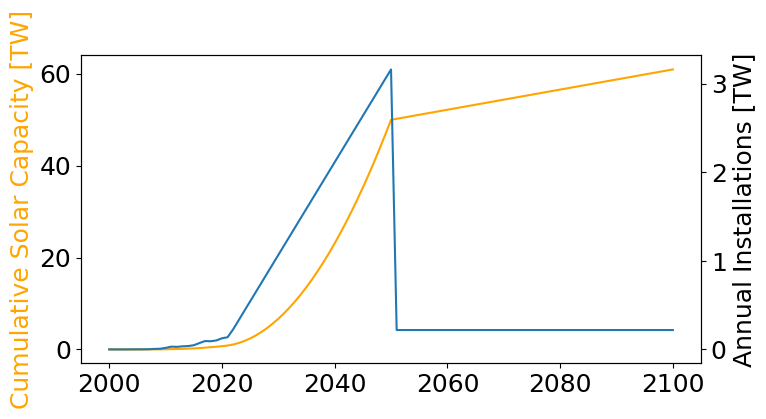

In [34]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.plot(global_projection['World_cum']/1e6, color='orange')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='orange')
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
plt.show()


In [35]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= global_projection['World_annual_[MWdc]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# Calculate Mass flow
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [36]:
sim1.calculateMassFlow()

>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

In [37]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [38]:
ii_cumu.loc[2100,'WasteAll_Module_sim1_Perovskite_[Tonnes]']

11075559.047412202

In [39]:
ii_cumu.loc[2100,'VirginStock_Module_sim1_Perovskite_[Tonnes]']

1582201492.3719165

In [40]:
ii_cumu.loc[2100,'WasteAll_Module_sim1_Perovskite_[Tonnes]']/ii_cumu.loc[2100,'VirginStock_Module_sim1_Perovskite_[Tonnes]']

0.007000093920281015

Text(0.5, 1.0, 'Effective Capacity: No Replacements')

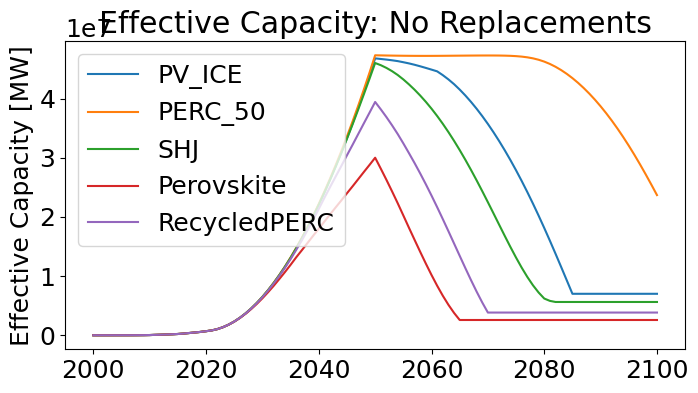

In [41]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity)
plt.legend(scennames)
plt.ylabel('Effective Capacity [MW]')
plt.title('Effective Capacity: No Replacements')

# Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. (i.e. not the PV ICE baseline)

#### Bifacial Factors

In [42]:
bifiFactors = {'PERC_50':0.7,
               'SHJ':0.9,
               'Perovskite': 0.0,
               'RecycledPERC':0.6,
              'PV_ICE':0.0} 

#MAY NEED TO CHANGE TO BE DYNAMIC
#              'TOPCon':0.8, # ITRPV 2022, Fig. 58
#               'Repowered':0.56

In [43]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [44]:
#currently takes 15 mins to run with 5 mateirals and 5 scenarios
for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    for scenario in range (0, len(sim1.scenario.keys())): #loop over scenarios
        scen = list(sim1.scenario.keys())[scenario] #select the nth scenario in a list of scenarios
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment
    sim1.calculateFlows(bifacialityfactors=bifiPathDict[scen]) #figure this out for multiple bifi factors


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144781876.5233016  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144820281.0764282  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1144976410.6503427  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1145170348.2681773  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1155710752.467505  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1172839040.9086597  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1194778370.361968  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1222742380.7688942  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1298789428.1225367  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1401547707.2613947  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1463526361.8712754  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1530668412.5989766  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1684711015.5564985  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1770181712.1462123  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1960574603.518677  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1953074681.0730107  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1943240434.9012132  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1937272254.1663437  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1931682674.1168828  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1916531537.9357598  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1921567729.1094747  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1926609950.8235602  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1976911091.378131  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1986924160.7139528  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1996180089.3925476  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2012978818.4500058  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2028143144.6745696  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2058545928.9416137  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2066821850.7398243  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2078397282.1259694  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2089230161.5038843  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2041435937.0455616  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1949646238.2147124  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1723312551.7876763  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1450774983.2074838  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1302038787.0899243  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1147472481.3079498  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  988622900.7310014  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  826853407.4663777  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  504952928.0539439  tonnes.
Recycl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  338859802.90142214  tonnes.
Recyc

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\743004246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  cop

In [45]:
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [46]:
sim1.plotMetricResults()

[]


# RESULTS: Effective Capacity and Replacements

In [168]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#451ab0','#c4008e','#fe1561','#ff7937','#ffc229']
import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 4)

scennames_labels = ['PV_ICE','PERC_50','SHJ','Perovskite','Recycled\nPERC']

Text(0.5, 1.0, 'Effective Capacity: With Replacements')

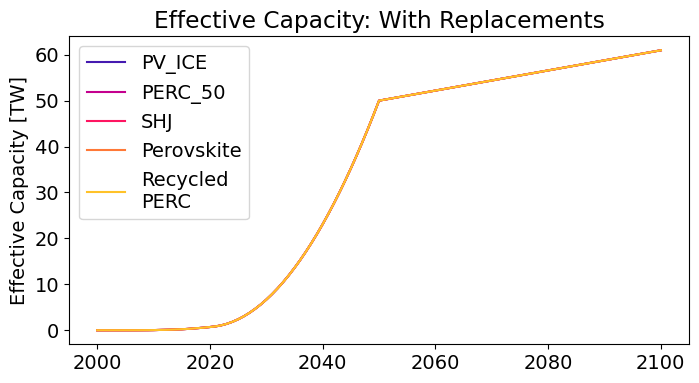

In [169]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(scennames_labels)
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')

Text(0.5, 1.0, 'Annual Decommissions [TW]')

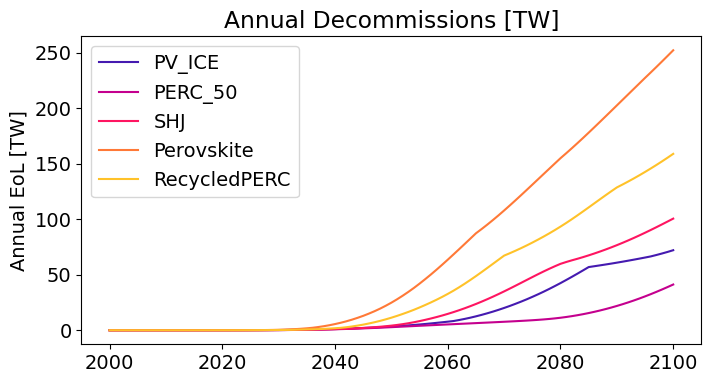

In [148]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(scennames_labels)
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')

Text(0.5, 1.0, 'Annual Installs with Replacements')

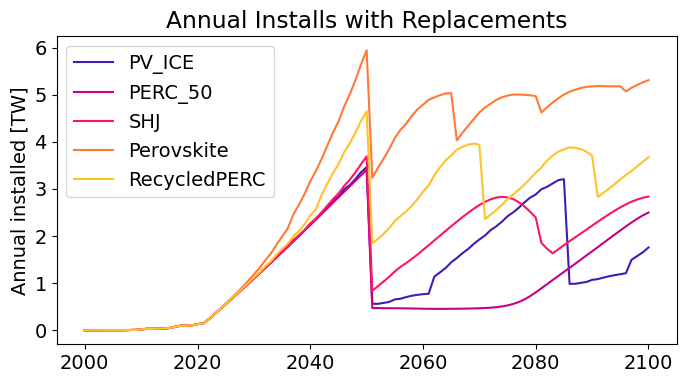

In [149]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(scennames_labels)
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')

Text(0.5, 1.0, 'Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')

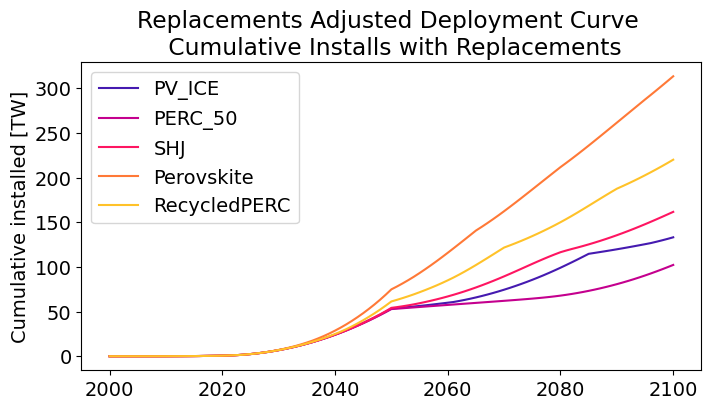

In [150]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(scennames_labels)
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')

Text(0.5, 1.0, 'Cumulative Installs with Replacements')

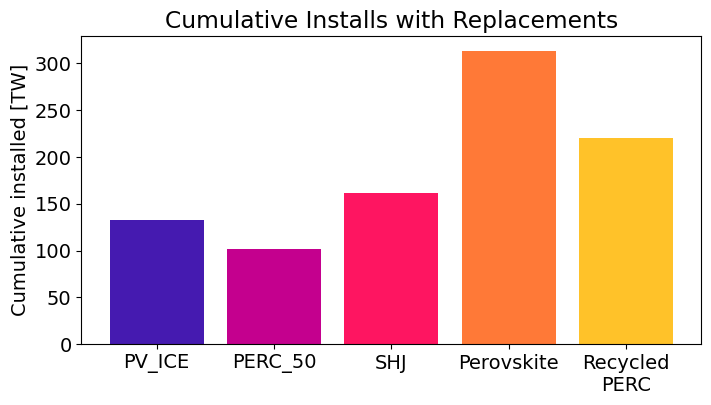

In [170]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')

In [52]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_cum'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

The nameplate installations for energy transition and through 2100 are 60.966 TW.


In [53]:
global_projection['World_annual_[MWdc]'].sum()

60966000.00000001

Text(0.5, 1.0, 'Replacements Required by Technology')

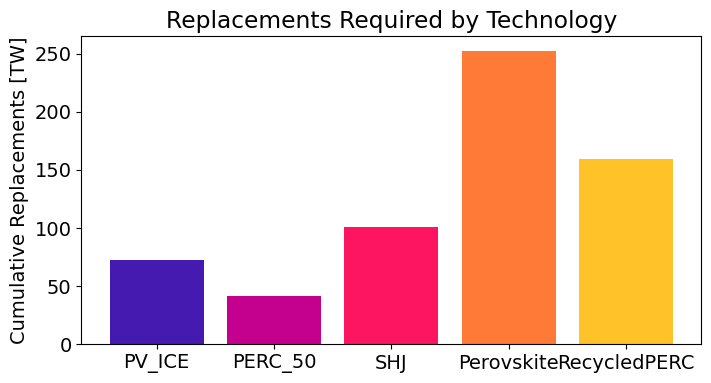

In [153]:
Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')

# RESULTS: Virgin Material Demands

Text(0, 0.5, 'Virgin Material Requirements\n[billion tonnes]')

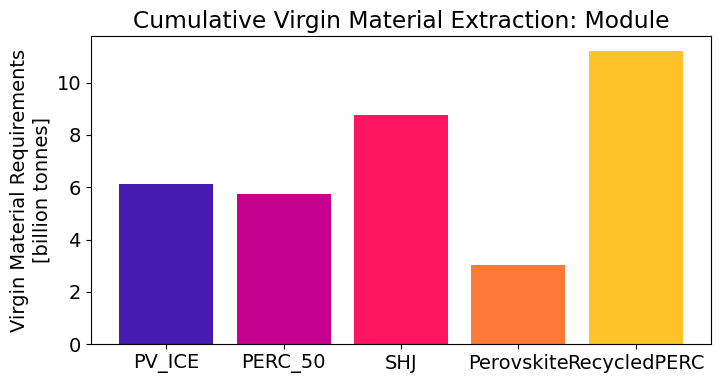

In [158]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')

Text(0, 0.5, 'Virgin Material Requirements\n[billion tonnes]')

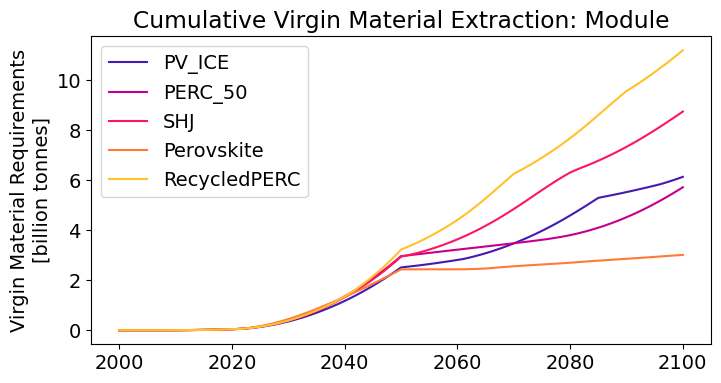

In [161]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')

Text(0, 0.5, 'Virgin Material Requirements\n[million tonnes]')

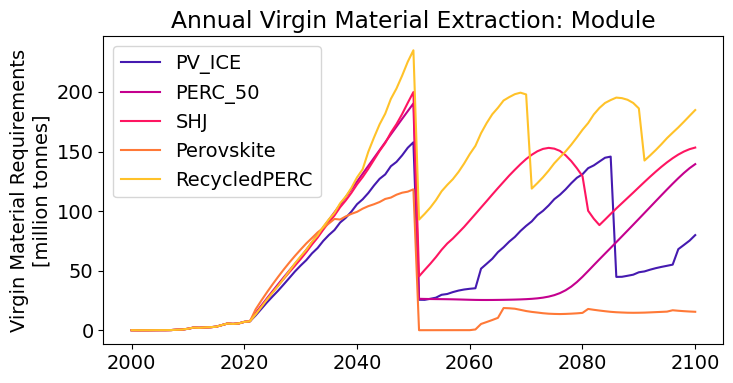

In [164]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')

# RESULTS: Lifecycle Wastes

Text(0, 0.5, 'Lifecycle Wastes\n[million tonnes]')

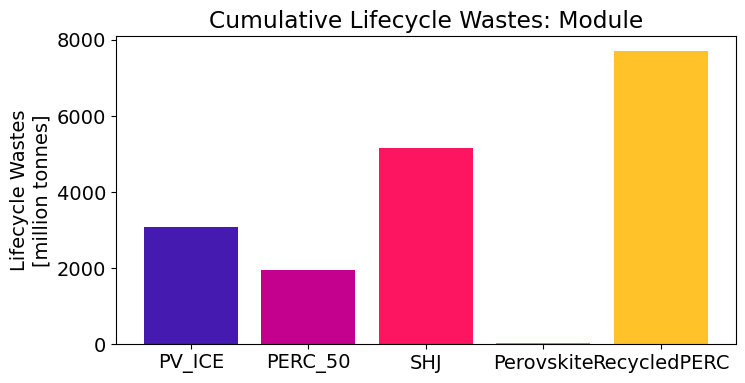

In [167]:
cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames, cumu_lifecycle_wastes.loc[2100]/1e6, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes: Module')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')

# RESULTS: Energy

In [61]:
#compile all energy out results
energy_mod=pd.DataFrame()
for scen in scennames:
    # add the scen name as a prefix for later filtering
    scende = sim1.scenario[scen].dataOut_e.add_prefix(str(scen+'_'))
    #concat into one large df
    energy_mod = pd.concat([energy_mod, scende], axis=1)

energy_mod.tail()

PV_ICE_mod_MFG  PV_ICE_mod_Install  PV_ICE_mod_OandM  PV_ICE_mod_Repair  \
96     1.548715e+13        4.342933e+10               0.0                0.0   
97     1.913930e+13        5.367075e+10               0.0                0.0   
98     2.014049e+13        5.647829e+10               0.0                0.0   
99     2.115829e+13        5.933244e+10               0.0                0.0   
100    2.245828e+13        6.297789e+10               0.0                0.0   

     PV_ICE_mod_Demount  PV_ICE_mod_Store  PV_ICE_mod_Resell_Certify  \
96         6.069446e+12               0.0                        0.0   
97         8.900401e+12               0.0                        0.0   
98         9.613525e+12               0.0                        0.0   
99         1.033756e+13               0.0                        0.0   
100        1.129268e+13               0.0                        0.0   

     PV_ICE_mod_ReMFG_Disassembly  PV_ICE_mod_Recycle_Crush  \
96                            0.0              1.249455e+11   
97                            0.0              1.763753e+11   
98                            0.0              1.903155e+11   
99                            0.0              2.044908e+11   
100                           0.0              2.226572e+11   

     PV_ICE_e_out_annual_[Wh]  ...  RecycledPERC_mod_MFG  \
96               9.485317e+16  ...          4.743571e+13   
97               9.519938e+16  ...          4.870670e+13   
98               9.554559e+16  ...          5.007676e+13   
99               9.589179e+16  ...          5.148944e+13   
100              9.623800e+16  ...          5.288102e+13   

     RecycledPERC_mod_Install  RecycledPERC_mod_OandM  \
96               1.330200e+11                     0.0   
97               1.365842e+11                     0.0   
98               1.404261e+11                     0.0   
99               1.443875e+11                     0.0   
100              1.482899e+11                     0.0   

     RecycledPERC_mod_Repair  RecycledPERC_mod_Demount  \
96                       0.0              1.708342e+13   
97                       0.0              1.765805e+13   
98                       0.0              1.831892e+13   
99                       0.0              1.904240e+13   
100                      0.0              1.979960e+13   

     RecycledPERC_mod_Store  RecycledPERC_mod_Resell_Certify  \
96                      0.0                              0.0   
97                      0.0                              0.0   
98                      0.0                              0.0   
99                      0.0                              0.0   
100                     0.0                              0.0   

     RecycledPERC_mod_ReMFG_Disassembly  RecycledPERC_mod_Recycle_Crush  \
96                                  0.0                    5.150993e+11   
97                                  0.0                    5.323087e+11   
98                                  0.0                    5.509245e+11   
99                                  0.0                    5.701689e+11   
100                                 0.0                    5.891617e+11   

     RecycledPERC_e_out_annual_[Wh]  
96                     9.485317e+16  
97                     9.519938e+16  
98                     9.554559e+16  
99                     9.589179e+16  
100                    9.623800e+16  

[5 rows x 50 columns]

In [62]:
energy_mat = pd.DataFrame()
for scen in scennames:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim1.scenario[scen].material[mat].matdataOut_e.add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat = pd.concat([energy_mat, scenmatde], axis=1)

energy_mat.tail()

PV_ICE_glass_mat_extraction  PV_ICE_glass_mat_MFG_virgin  \
96                  4.927838e+11                 1.675174e+14   
97                  6.089762e+11                 2.070160e+14   
98                  6.408289e+11                 2.178440e+14   
99                  6.732102e+11                 2.288518e+14   
100                 7.145692e+11                 2.429114e+14   

     PV_ICE_glass_mat_MFGScrap_LQ  PV_ICE_glass_mat_MFGScrap_HQ  \
96                   1.592312e+12                  3.184623e+11   
97                   1.967807e+12                  3.935615e+11   
98                   2.070744e+12                  4.141489e+11   
99                   2.175390e+12                  4.350780e+11   
100                  2.309048e+12                  4.618096e+11   

     PV_ICE_glass_mat_Landfill  PV_ICE_glass_mat_EoL_ReMFG_clean  \
96                2.847853e+12                               0.0   
97                4.006582e+12                               0.0   
98                4.320715e+12                               0.0   
99                4.640144e+12                               0.0   
100               5.049488e+12                               0.0   

     PV_ICE_glass_mat_Recycled_LQ  PV_ICE_glass_mat_Recycled_HQ  \
96                   2.379096e+12                  1.427458e+11   
97                   3.358374e+12                  2.015024e+11   
98                   3.623809e+12                  2.174286e+11   
99                   3.893722e+12                  2.336233e+11   
100                  4.239630e+12                  2.543778e+11   

     PV_ICE_silver_mat_extraction  PV_ICE_silver_mat_MFG_virgin  ...  \
96                   2.791014e+08                  2.721239e+12  ...   
97                   3.449185e+08                  3.362955e+12  ...   
98                   3.629614e+08                  3.538873e+12  ...   
99                   3.813037e+08                  3.717711e+12  ...   
100                  4.047314e+08                  3.946131e+12  ...   

     RecycledPERC_copper_mat_Recycled_LQ  RecycledPERC_copper_mat_Recycled_HQ  \
96                                   0.0                                  0.0   
97                                   0.0                                  0.0   
98                                   0.0                                  0.0   
99                                   0.0                                  0.0   
100                                  0.0                                  0.0   

     RecycledPERC_aluminium_frames_mat_extraction  \
96                                   1.824080e+14   
97                                   1.872261e+14   
98                                   1.924184e+14   
99                                   1.977712e+14   
100                                  2.030434e+14   

     RecycledPERC_aluminium_frames_mat_MFG_virgin  \
96                                   3.391274e+14   
97                                   3.480851e+14   
98                                   3.577385e+14   
99                                   3.676903e+14   
100                                  3.774922e+14   

     RecycledPERC_aluminium_frames_mat_MFGScrap_LQ  \
96                                    1.229520e+12   
97                                    1.262464e+12   
98                                    1.297976e+12   
99                                    1.334592e+12   
100                                   1.370661e+12   

     RecycledPERC_aluminium_frames_mat_MFGScrap_HQ  \
96                                    1.217225e+12   
97                                    1.249840e+12   
98                                    1.284996e+12   
99                                    1.321246e+12   
100                                   1.356955e+12   

     RecycledPERC_aluminium_frames_mat_Landfill  \
96                                 1.240837e+12   
97                                 1.282290e+12   
98                                 1.3

In [63]:
allenergy = pd.concat([energy_mod,energy_mat], axis=1)
allenergy.index=idx_temp
allenergy

## Energy Generation
Check that they all produce the same amount of energy

Text(0, 0.5, 'Energy Generation [TWh]')

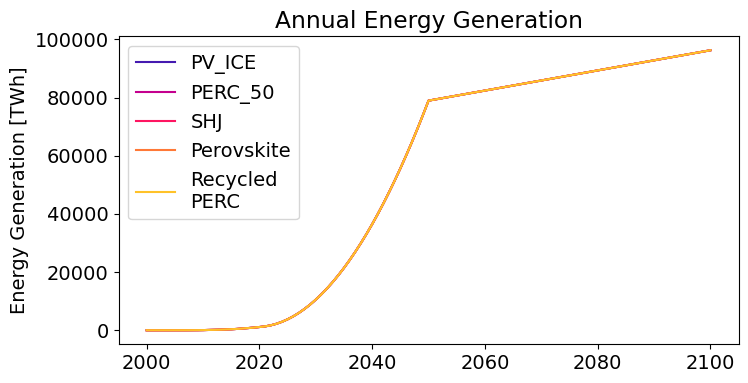

In [171]:
energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')

## Net Energy

In [67]:
#categorize the energy in values into lifecycle stages
mfg_energies = ['mod_MFG','mat_extraction','mat_MFG_virgin']
mfg_recycle_energies_LQ = ['mat_MFGScrap_LQ'] #LQ and HQ are separate becuase LQ is only LQ
mfg_recycle_energies_HQ = ['mat_MFGScrap_HQ'] #and HQ material is E_LQ + E_HQ
use_energies = ['mod_Install','mod_OandM','mod_Repair']
eol_energies = ['mat_Landfill','mod_Demount','mod_Store','mod_Resell_Certify']
eol_remfg_energies = ['mod_ReMFG_Disassmbly','mat_EoL_ReMFG_clean']
eol_recycle_energies_LQ = ['mod_Recycle_Crush','mat_Recycled_LQ']
eol_recycle_energies_HQ = ['mod_Recycle_Crush','mat_Recycled_HQ']

energy_demands_keys = [mfg_energies,mfg_recycle_energies_LQ,mfg_recycle_energies_HQ,use_energies,eol_energies,
                  eol_remfg_energies,eol_recycle_energies_LQ,eol_recycle_energies_HQ]
import itertools
energy_demands_flat = list(itertools.chain(*energy_demands_keys))
#energy_demands_flat

In [72]:
#for each scenario, create a cumulative total energy demand
energy_demands = allenergy.loc[:,~allenergy.columns.isin(energyGen.columns)] 

for scen in scennames:
    colname = str(scen+'_e_demand_total')
    energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\2189604799.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\2189604799.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_4840\2189604799.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [75]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

Text(0, 0.5, 'Energy Demands\n[TWh]')

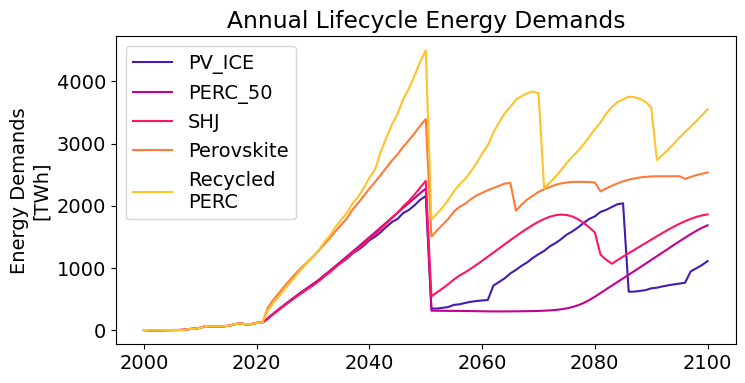

In [173]:
plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels)
plt.title('Annual Lifecycle Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')

In [80]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

Text(0, 0.5, 'Cumulative Energy Demands\n[TWh]')

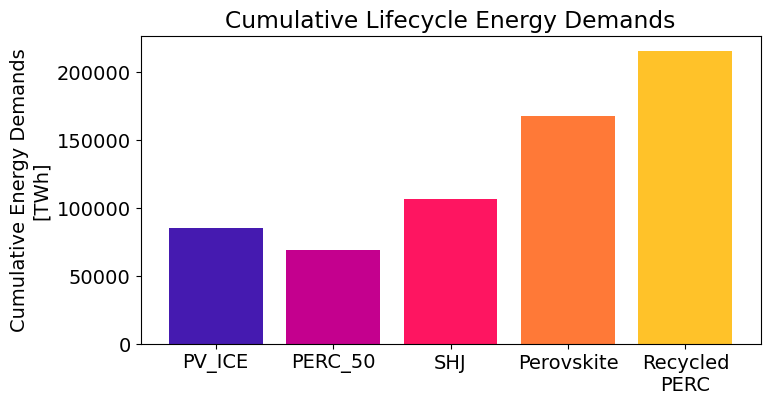

In [175]:
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')

In [94]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [95]:
e_annual_sumDemands_cumu.loc[[2100]]

PV_ICE       PERC_50           SHJ    Perovskite  RecycledPERC
2100  8.554033e+16  6.943756e+16  1.065417e+17  1.681007e+17  2.156104e+17

In [101]:
netEnergy_cumu

PV_ICE       PERC_50           SHJ    Perovskite  RecycledPERC
2100  5.175779e+18  5.191882e+18  5.154778e+18  5.093218e+18  5.045709e+18

In [102]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm

PV_ICE   PERC_50       SHJ  Perovskite  RecycledPERC
2100     1.0  1.003111  0.995942    0.984049      0.974869

<module 'matplotlib.pyplot' from 'C:\\Users\\hmirletz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

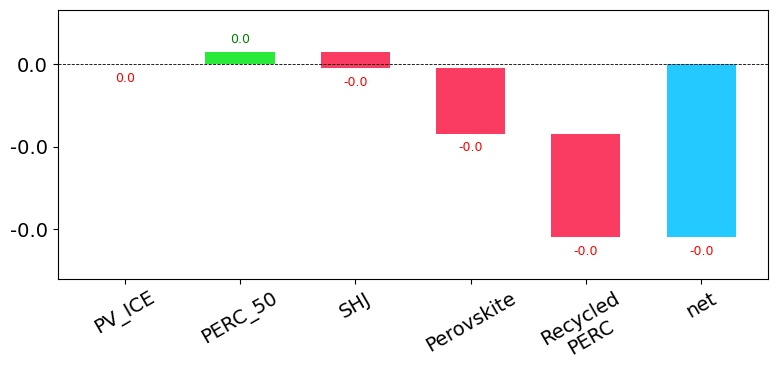

In [208]:
import waterfall_chart as waterfall #use pip install waterfall_charts

netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm.loc[[2100]]-1
netEnergy_cumu_norm_waterfall
waterfall.plot(scennames_labels, netEnergy_cumu_norm_waterfall.loc[2100])

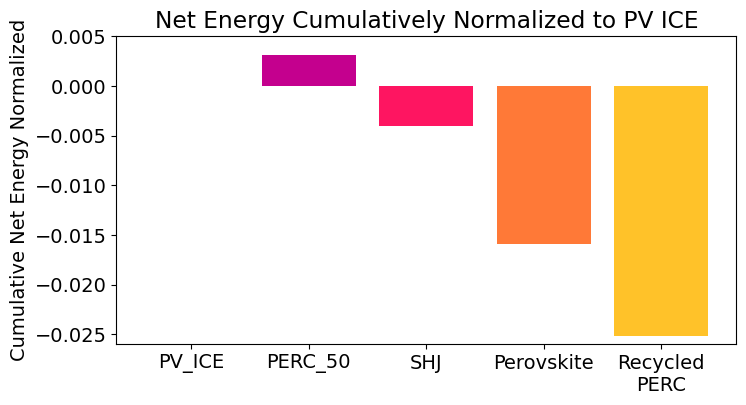

In [223]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Normalized to PV ICE')
plt.ylabel('Cumulative Net Energy Normalized')
plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)

Text(0, 0.5, 'Cumulative Net Energy\n[TWh]')

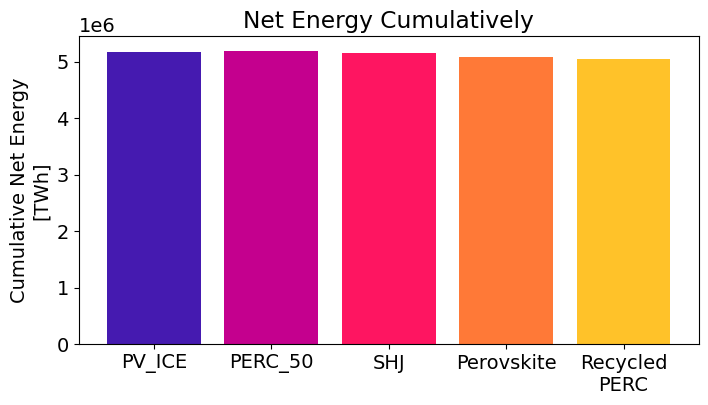

In [179]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy\n[TWh]')

In [186]:
energyGen.columns = e_annual_sumDemands.columns = scennames
annual_net_energy = energyGen - e_annual_sumDemands

(2040.0, 2100.0)

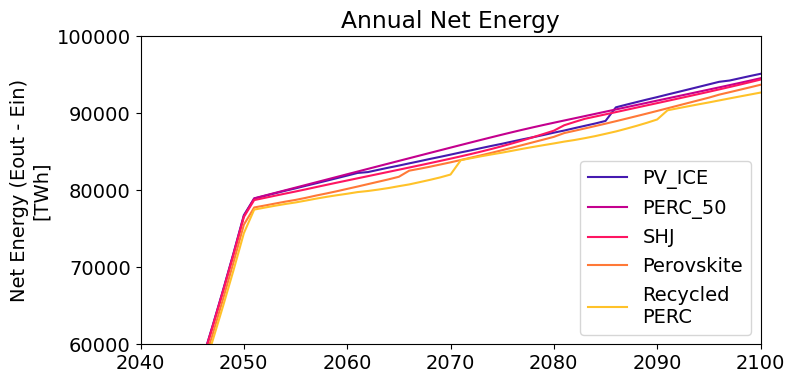

In [190]:
plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(60000,100000)
plt.xlim(2040,2100)

# CE-TE Metric
Net Energy over Linear mass flow

In [200]:
#cumulatively
netEnergy_cumu.columns = cumu_virgin_module.columns = cumu_lifecycle_wastes.columns = scennames_labels

CETEmetric = (netEnergy_cumu.loc[2100]/1e6)/ (cumu_virgin_module.loc[2100]+ cumu_lifecycle_wastes.loc[2100])

Text(0, 0.5, 'Net Energy / Linear Mass \n[MWh/tonne]')

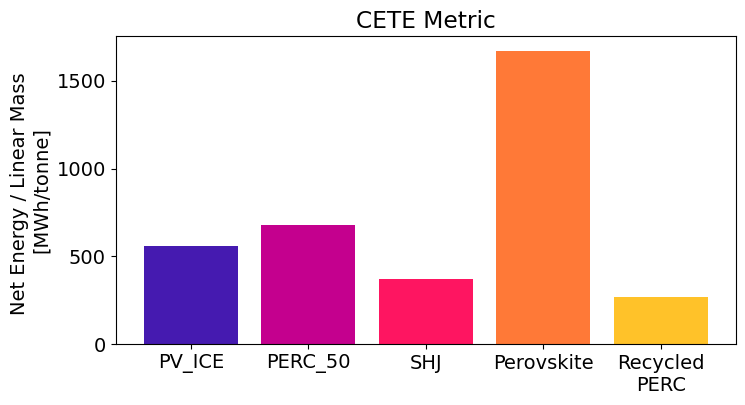

In [201]:
plt.bar(CETEmetric.index, CETEmetric, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('CETE Metric')
plt.ylabel('Net Energy / Linear Mass \n[MWh/tonne]')

## EROI

##

# To Do
- energy requirements on a per MW installed for a single install, what is MFG
- Y axis = normalized net energy of perovskites, x axis = remanufacturing energy variation, maybe add recycling Just change one variable 

- EROI
- CETE Metric

lowest nergy = remfg
mid energy = recycle
high energy = virgin mfg